In [3]:
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
from mpl_toolkits.basemap import Basemap
from sodapy import Socrata
from utils import get_connection, load_saved_data

In [29]:
client = get_connection()

In [16]:
number_per_year = """
SELECT
    date_extract_y(created_date) as year,
    count(unique_key) as entries
GROUP BY
    year
"""

npy_results = client.get("erm2-nwe9", query=number_per_year)
npy_df = pd.DataFrame.from_records(npy_results)
npy_df


year  entries
0   2010  2089787
1   2011  2011176
2   2012  1837124
3   2013  1887594
4   2014  2156743
5   2015  2322511
6   2016  2409047
7   2017  2508523
8   2018  2760144
9   2019  2633181
10  2020  2942060
11  2021  3220907
12  2022  3169802
13  2023  3225110
14  2024   329409

In [28]:
npy_df = npy_df.astype(int)

npy_df.plot(
    x="year", y="entries",
    kind='line', title="NYC 311 Requests (Millions) by Year",
    xlabel="Year", ylabel="Opened Requests (Millions)",
    legend=False
)
# npy_df.plot()

<Axes: title={'center': 'NYC 311 Requests (Millions) by Year'}, xlabel='Year', ylabel='Opened Requests (Millions)'>

In [142]:
agency_name_map_q = """
SELECT DISTINCT
    agency, agency_name
WHERE agency IS NOT NULL AND agency_name IS NOT NULL
LIMIT 20000
"""
agency_name_results = client.get("erm2-nwe9", content_type="json", query=agency_name_map_q)
agname_df = pd.DataFrame.from_records(agency_name_results)
agname_df

agency                                        agency_name
0       DOE             School - The Stephanie A Vierno School
1       DOE                School - John F Kennedy High School
2       DOE  School - Mark Twain IS 239 for the Gifted and ...
3       DOE           School - East Side Community High School
4       DOE                  School - Far Rockaway High School
...     ...                                                ...
1884    DOE                                    School - PS 295
1885    DOE   School - Brownsville Collaborative Middle School
1886    DOE               School - Academy for Young Writers A
1887    DOE                   School - East Side Middle School
1888    DOE                  School - PS X140 The Eagle School

[1889 rows x 2 columns]

In [157]:
agname_dict = agname_df.set_index("agency")
agname_dict = agname_dict.groupby(agname_dict.index).apply(lambda x: x.to_dict(orient="records")).to_dict()
for k, v in agname_dict.items():
    agname_dict[k] = list(chain(*[list(c.values()) for c in v]))
# agname_dict

In [4]:
# focus on 2017-2023
try:
    q2017_df = load_saved_data()
except FileNotFoundError or TypeError:
    q2017 = """
    SELECT
        created_date,
        closed_date,
        agency,
        complaint_type,
        descriptor,
        status,
        resolution_description,
        due_date,
        resolution_action_updated_date,
        latitude,
        longitude
    WHERE
        date_extract_y(created_date)=2017 OR
        date_extract_y(closed_date)=2017
    LIMIT 200000
    """

    q2017_results = client.get("erm2-nwe9", content_type="json", query=q2017)
    q2017_df = pd.DataFrame.from_records(q2017_results)


In [5]:
q2017_df

created_date         closed_date agency  \
0      2018-06-11 12:12:00 2017-11-27 00:00:00    DEP   
1      2018-05-11 11:51:00 2017-03-10 00:00:00    DEP   
2      2018-05-01 09:19:00 2017-07-19 00:00:00    DEP   
3      2018-04-27 09:21:00 2017-09-21 00:00:00    DEP   
4      2018-03-14 00:00:00 2017-03-15 15:30:00  DOHMH   
...                    ...                 ...    ...   
199995 2017-12-04 08:25:56 2017-12-04 09:53:03    DHS   
199996 2017-12-04 08:25:32 2017-12-11 10:26:58    DOT   
199997 2017-12-04 08:25:32 2017-12-08 13:05:45    DOT   
199998 2017-12-04 08:25:00 2017-12-06 12:00:00   DSNY   
199999 2017-12-04 08:25:00 2017-12-06 02:08:32    HPD   

                           complaint_type   status  \
0                                    FATF  Pending   
1                                    FATF  Pending   
2                                    FATF  Pending   
3                                    FATF  Pending   
4                          Food Poisoning  Pending   
...                                   ...      ...   
199995         Homeless Person Assistance   Closed   
199996                   Street Condition   Closed   
199997             Street Sign - Dangling   Closed   
199998  Missed Collection (All Materials)   Closed   
199999                     HEAT/HOT WATER   Closed   

       resolution_action_updated_date   latitude  longitude  \
0                 2017-11-27 00:00:00  40.590094 -73.932163   
1                 2017-03-10 00:00:00  40.734382 -73.864309   
2                 2017-07-19 00:00:00  40.734605 -73.864774   
3                 2017-09-21 00:00:00  40.778421 -73.894593   
4                 2017-03-15 15:30:00  40.814362 -73.913257   
...                               ...        ...        ...   
199995            2017-12-04 09:53:03  40.882710 -73.881246   
199996            2017-12-11 10:26:58  40.664933 -73.931474   
199997            2017-12-08 13:05:45  40.801400 -73.954222   
199998            2017-12-06 12:00:00  40.827830 -73.906312   
199999            2017-12-06 02:08:32  40.857647 -73.897833   

                            descriptor  \
0                                 None   
1                                 None   
2                                 None   
3                                 None   
4                            3 or More   
...                                ...   
199995                             N/A   
199996         Plate Condition - Noisy   
199997  No Parking, Standing, Stopping   
199998             1 Missed Collection   
199999                 ENTIRE BUILDING   

                                   resolution_description            due_date  
0                                                    None                 NaT  
1                                                    None                 NaT  
2                                                    None                 NaT  
3                                                    None                 NaT  
4       Callers should contact the DOHMH Foodborne Ill... 2018-03-28 12:47:14  
...                                                   ...                 ...  
199995  The mobile outreach response team offered serv... 2017-12-04 11:51:57  
199996  The Department of Transportation inspected the... 2017-12-14 08:25:32  
199997  The Department of Transportation has completed... 2017-12-21 08:29:06  
199998  The Department of Sanitation investigated this...                 NaT  
199999  The Department of Housing Preservation and Dev...                 NaT  

[200000 rows x 11 columns]

In [6]:
# q2017_df.convert_dtypes(dtype_backend="pyarrow")
# q2017_df.to_feather("2017_1_200k.feather")
# q2017_df.to_datetime()

In [7]:
q2017_df[q2017_df["status"]!="Closed"]

created_date         closed_date agency          complaint_type  \
0      2018-06-11 12:12:00 2017-11-27 00:00:00    DEP                    FATF   
1      2018-05-11 11:51:00 2017-03-10 00:00:00    DEP                    FATF   
2      2018-05-01 09:19:00 2017-07-19 00:00:00    DEP                    FATF   
3      2018-04-27 09:21:00 2017-09-21 00:00:00    DEP                    FATF   
4      2018-03-14 00:00:00 2017-03-15 15:30:00  DOHMH          Food Poisoning   
...                    ...                 ...    ...                     ...   
199949 2017-12-04 08:32:00 2017-12-01 08:32:00    DOT  Street Light Condition   
199950 2017-12-04 08:32:00 2017-12-01 08:32:00    DOT  Street Light Condition   
199957 2017-12-04 08:31:00 2017-12-01 08:31:00    DOT  Street Light Condition   
199962 2017-12-04 08:30:00 2017-12-01 08:30:00    DOT  Street Light Condition   
199963 2017-12-04 08:30:00 2017-12-01 08:30:00    DOT  Street Light Condition   

         status resolution_action_updated_date   latitude  longitude  \
0       Pending            2017-11-27 00:00:00  40.590094 -73.932163   
1       Pending            2017-03-10 00:00:00  40.734382 -73.864309   
2       Pending            2017-07-19 00:00:00  40.734605 -73.864774   
3       Pending            2017-09-21 00:00:00  40.778421 -73.894593   
4       Pending            2017-03-15 15:30:00  40.814362 -73.913257   
...         ...                            ...        ...        ...   
199949  Pending            2017-12-01 08:32:00        NaN        NaN   
199950  Pending            2017-12-01 08:32:00        NaN        NaN   
199957  Pending            2017-12-01 08:31:00        NaN        NaN   
199962  Pending            2017-12-01 08:30:00        NaN        NaN   
199963  Pending            2017-12-01 08:30:00        NaN        NaN   

                       descriptor  \
0                            None   
1                            None   
2                            None   
3                            None   
4                       3 or More   
...                           ...   
199949  Fixture/Luminaire Missing   
199950       Street Light Cycling   
199957           Street Light Out   
199962       Street Light Cycling   
199963       Street Light Cycling   

                                   resolution_description            due_date  
0                                                    None                 NaT  
1                                                    None                 NaT  
2                                                    None                 NaT  
3                                                    None                 NaT  
4       Callers should contact the DOHMH Foodborne Ill... 2018-03-28 12:47:14  
...                                                   ...                 ...  
199949  Service Request status for this request is ava...                 NaT  
199950  Service Request status for this request is ava...                 NaT  
199957  Service Request status for this request is ava...                 NaT  
199962  Service Request status for this request is ava...                 NaT  
199963  Service Request status for this request is ava...                 NaT  

[3839 rows x 11 columns]

In [8]:
q2017_df.describe().T.convert_dtypes().T


created_date                    closed_date  \
count                         200000                         197542   
mean   2017-12-18 03:17:13.427325184  2018-01-03 12:27:24.242201600   
min              2017-12-04 08:25:00            2001-01-01 01:04:44   
25%              2017-12-11 10:05:01            2017-12-14 12:00:00   
50%       2017-12-17 20:29:09.500000            2017-12-22 12:00:00   
75%    2017-12-26 08:32:08.750000128            2017-12-31 12:00:00   
max              2018-06-11 12:12:00            2024-01-11 00:00:00   
std                             <NA>                           <NA>   

      resolution_action_updated_date   latitude  longitude  \
count                         198476     186050     186050   
mean   2018-01-03 15:48:31.371556096  40.733909 -73.923255   
min              2017-01-02 15:47:00  40.499659 -74.254723   
25%              2017-12-14 11:29:21  40.666206 -73.962472   
50%              2017-12-22 12:00:00  40.725261 -73.924717   
75%              2017-12-31 09:49:52  40.819748 -73.880881   
max              2024-01-11 00:00:00  40.912869 -73.701099   
std                             <NA>   0.087958   0.077249   

                            due_date  
count                          69911  
mean   2017-12-31 03:07:56.228304128  
min              2017-12-01 11:28:13  
25%       2017-12-14 07:35:28.500000  
50%              2017-12-22 10:03:40  
75%              2017-12-31 00:49:27  
max              2019-12-21 12:26:25  
std                             <NA>

In [9]:
q2017_df.describe(include="object")

agency  complaint_type  status       descriptor  \
count   200000          200000  200000           199924   
unique      22             201       6              878   
top        HPD  HEAT/HOT WATER  Closed  ENTIRE BUILDING   
freq     73061           45838  196161            28698   

                                   resolution_description  
count                                              189456  
unique                                                517  
top     The complaint you filed is a duplicate of a co...  
freq                                                20113

In [10]:
# Percentage left pending
len(q2017_df[q2017_df["status"]!="Closed"])/len(q2017_df)

0.019195

In [13]:
created_by_date_by_agency = q2017_df.groupby(by=[q2017_df["created_date"].dt.date,q2017_df["created_date"].dt.hour, q2017_df["agency"]])["created_date"].count()
created_by_date_by_agency.index.set_names(['created_date', 'hour', 'agency'], inplace=True)

ab = created_by_date_by_agency.unstack().reset_index()
ab["time"] = pd.to_datetime(ab["created_date"].astype(str)+" "+ab["hour"].astype(str)+":00:00")
ab.drop(["created_date", "hour"], axis=1, inplace=True)
ab.set_index("time", inplace=True)
ab

agency               ACS  COIB  DCA  DCAS   DEP  DFTA  DHS   DOB  DOE   DOF  \
time                                                                          
2017-12-04 08:00:00  NaN   NaN  NaN   NaN  13.0   NaN  3.0  15.0  NaN   2.0   
2017-12-04 09:00:00  1.0   NaN  3.0   NaN  46.0   6.0  5.0  51.0  NaN  37.0   
2017-12-04 10:00:00  NaN   NaN  5.0   NaN  40.0   3.0  3.0  56.0  3.0  34.0   
2017-12-04 11:00:00  NaN   NaN  6.0   NaN  49.0   2.0  2.0  39.0  1.0  45.0   
2017-12-04 12:00:00  1.0   NaN  3.0   NaN  29.0   4.0  3.0  50.0  NaN  32.0   
...                  ...   ...  ...   ...   ...   ...  ...   ...  ...   ...   
2018-03-14 00:00:00  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN   
2018-04-27 09:00:00  NaN   NaN  NaN   NaN   1.0   NaN  NaN   NaN  NaN   NaN   
2018-05-01 09:00:00  NaN   NaN  NaN   NaN   1.0   NaN  NaN   NaN  NaN   NaN   
2018-05-11 11:00:00  NaN   NaN  NaN   NaN   1.0   NaN  NaN   NaN  NaN   NaN   
2018-06-11 12:00:00  NaN   NaN  NaN   NaN   1.0   NaN  NaN   NaN  NaN   NaN   

agency               ...    DOT   DPR   DSNY  EDC    HPD  HRA  NYCEM   NYPD  \
time                 ...                                                      
2017-12-04 08:00:00  ...   38.0   1.0   50.0  NaN   68.0  NaN    2.0   54.0   
2017-12-04 09:00:00  ...   61.0  20.0   94.0  1.0  138.0  2.0    4.0  109.0   
2017-12-04 10:00:00  ...   84.0  11.0  122.0  NaN  144.0  4.0    NaN   67.0   
2017-12-04 11:00:00  ...  104.0  14.0  102.0  NaN  172.0  5.0    NaN   63.0   
2017-12-04 12:00:00  ...   31.0  12.0  205.0  NaN  168.0  8.0    NaN   74.0   
...                  ...    ...   ...    ...  ...    ...  ...    ...    ...   
2018-03-14 00:00:00  ...    NaN   NaN    NaN  NaN    NaN  NaN    NaN    NaN   
2018-04-27 09:00:00  ...    NaN   NaN    NaN  NaN    NaN  NaN    NaN    NaN   
2018-05-01 09:00:00  ...    NaN   NaN    NaN  NaN    NaN  NaN    NaN    NaN   
2018-05-11 11:00:00  ...    NaN   NaN    NaN  NaN    NaN  NaN    NaN    NaN   
2018-06-11 12:00:00  ...    NaN   NaN    NaN  NaN    NaN  NaN    NaN    NaN   

agency               TAX  TLC  
time                           
2017-12-04 08:00:00  NaN  3.0  
2017-12-04 09:00:00  NaN  5.0  
2017-12-04 10:00:00  NaN  6.0  
2017-12-04 11:00:00  NaN  6.0  
2017-12-04 12:00:00  NaN  6.0  
...                  ...  ...  
2018-03-14 00:00:00  NaN  NaN  
2018-04-27 09:00:00  NaN  NaN  
2018-05-01 09:00:00  NaN  NaN  
2018-05-11 11:00:00  NaN  NaN  
2018-06-11 12:00:00  NaN  NaN  

[676 rows x 22 columns]

In [14]:
agency_created_log = ab.apply(lambda x: np.log(x))
agency_created_log.fillna(0,inplace=True)

agency_created_log = agency_created_log[agency_created_log.mean().sort_values(ascending=False).index]

agency_created_log = agency_created_log.set_index(pd.to_datetime(agency_created_log.index))
ax = agency_created_log[:"2018-01-01"].plot(cmap=plt.cm.gist_ncar)
# ax = agency_created[:"2018-01-01"].plot.area(stacked=True, cmap=plt.cm.RdGy)
ax.legend(loc="upper right", ncol=2,bbox_to_anchor=[1.25,1])
ax.set_xlabel("Date")
ax.set_ylabel("Log Number of Requests Created")
ax.set_title("Log Number of Requests Created by Date by Agency")
fig = ax.get_figure()
fig.set_size_inches(15,10)

In [32]:
# ax = agency_created_log[:"2018-01-01"].plot(cmap=plt.cm.gist_ncar)
agency_created_log = agency_created_log[agency_created_log.mean().sort_values(ascending=True).index]

ax = agency_created_log[:"2018-01-01"].plot.area(stacked=True, cmap=plt.cm.RdGy)
ax.legend(loc="upper right", ncol=1,bbox_to_anchor=[1.1,1])
ax.set_xlabel("Date")
ax.set_ylabel("Log Number of Requests Created")
ax.set_title("Log Number of Requests Created by Hour by Agency")
fig = ax.get_figure()
fig.set_size_inches(15,10)

In [33]:
agency_created = ab.fillna(0)
agency_created = agency_created[agency_created.mean().sort_values(ascending=False).index]
# agency_created.plot()
agency_created = agency_created.set_index(pd.to_datetime(agency_created.index))
ax = agency_created[:"2018-01-01"].plot.area(stacked=True, cmap=plt.cm.RdGy)
ax.legend(loc="upper right", ncol=1,bbox_to_anchor=[1.1,1])
ax.set_xlabel("Date")
ax.set_ylabel("Number of Requests Created")
ax.set_title("Number of Requests Created by Hour by Agency")
fig = ax.get_figure()
fig.set_size_inches(15,10)

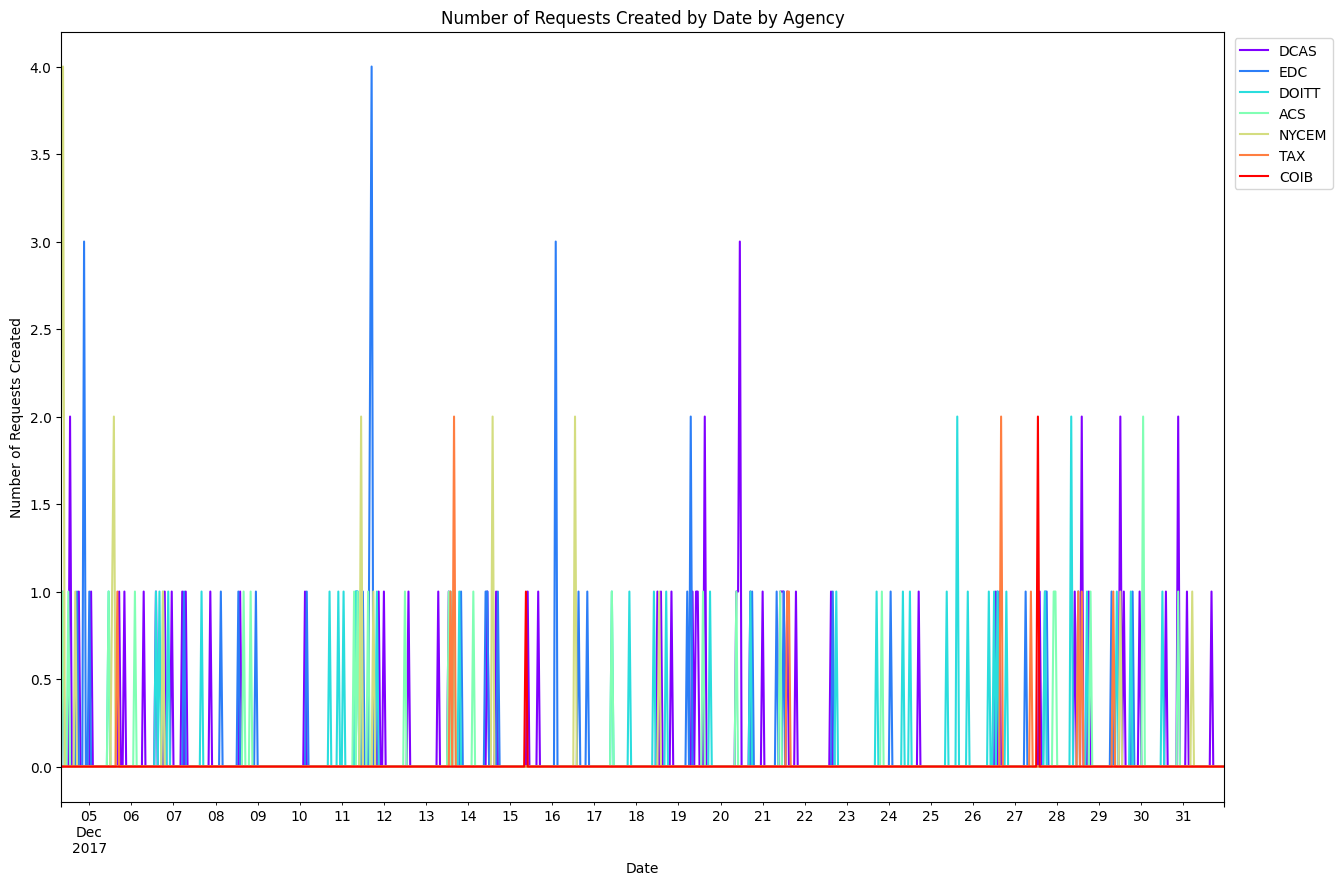

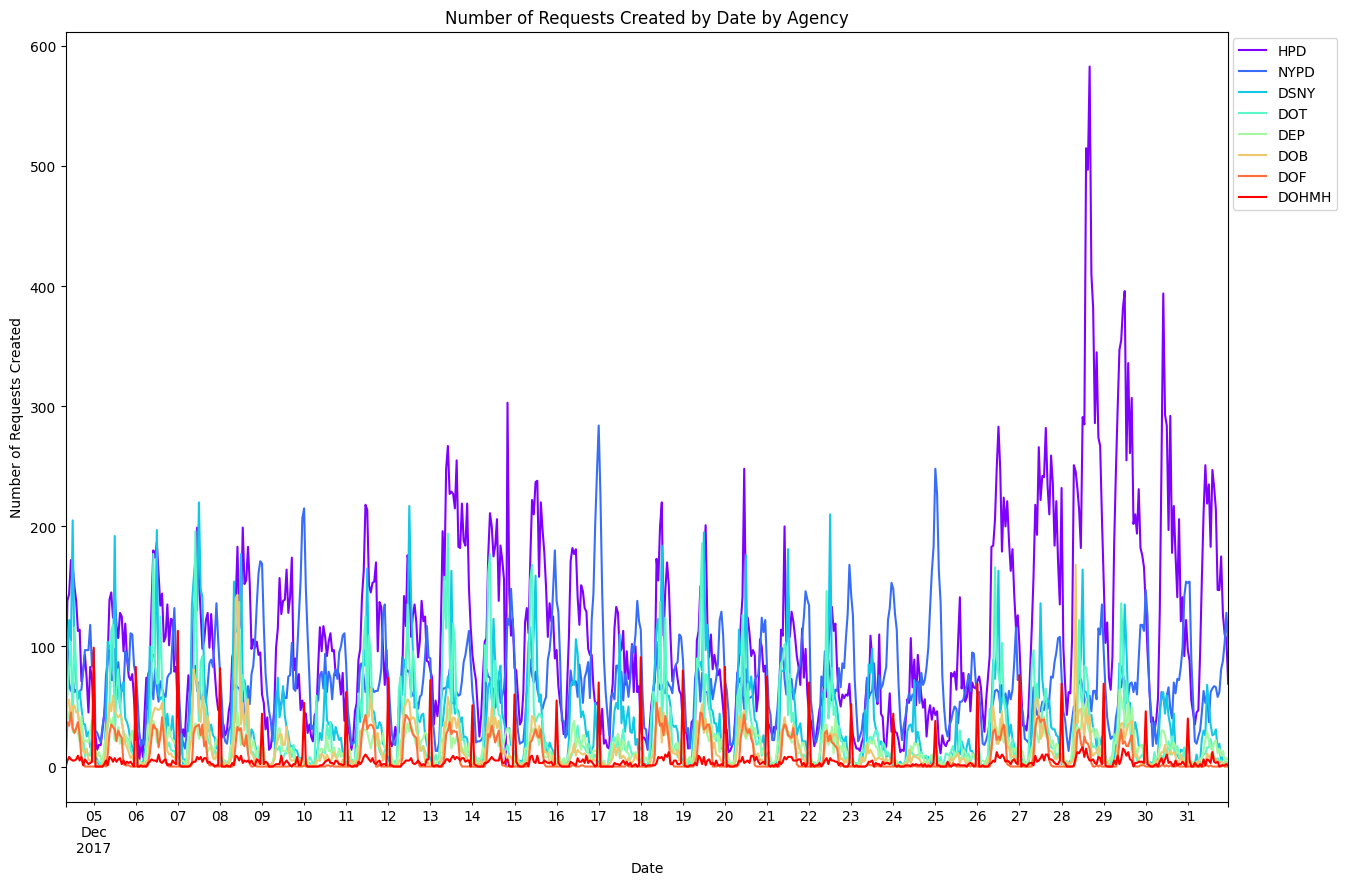

In [53]:
bin_lbls = ["low","mid","high"]
q1, bins = pd.qcut(agency_created.mean(), 3, labels=bin_lbls, retbins=True,duplicates="raise")

for lbl in bin_lbls:
    l1 = agency_created[q1[q1==lbl].index]
    l1 = l1[l1.mean().sort_values(ascending=False).index]

    l1 = l1.set_index(pd.to_datetime(agency_created_log.index))
    ax = l1[:"2018-01-01"].plot(cmap=plt.cm.rainbow)
    # ax = agency_created[:"2018-01-01"].plot.area(stacked=True, cmap=plt.cm.RdGy)
    ax.legend(loc="upper right", ncol=1,bbox_to_anchor=[1.1,1])
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Requests Created")
    ax.set_title("Number of Requests Created by Date by Agency")
    fig = ax.get_figure()
    fig.set_size_inches(15,10)

In [47]:
created_by_date_by_agency = q2017_df.groupby(by=[q2017_df["created_date"].dt.date, q2017_df["agency"]])["created_date"].count()
created_by_date_by_agency.index.set_names(['created_date', 'agency'], inplace=True)

cf = created_by_date_by_agency.unstack().reset_index()
cf["time"] = pd.to_datetime(cf["created_date"])
cf.drop(["created_date"], axis=1, inplace=True)
cf.set_index("time", inplace=True)
cf

agency      ACS  COIB   DCA  DCAS    DEP  DFTA   DHS    DOB   DOE    DOF  ...  \
time                                                                      ...   
2017-12-04  2.0   NaN  49.0   3.0  479.0  39.0  49.0  461.0   6.0  282.0  ...   
2017-12-05  1.0   NaN  51.0   3.0  526.0  41.0  66.0  531.0  20.0  244.0  ...   
2017-12-06  2.0   NaN  54.0   4.0  516.0  30.0  45.0  479.0   5.0  246.0  ...   
2017-12-07  NaN   NaN  31.0   3.0  458.0  32.0  35.0  596.0   5.0  238.0  ...   
2017-12-08  2.0   NaN  54.0   1.0  405.0  29.0  27.0  696.0   3.0  196.0  ...   
2017-12-09  NaN   NaN  44.0   NaN  245.0   5.0  24.0  236.0   1.0    3.0  ...   
2017-12-10  NaN   NaN  25.0   1.0  217.0   8.0  37.0  111.0   3.0    4.0  ...   
2017-12-11  4.0   NaN  40.0   1.0  433.0  22.0  65.0  475.0   6.0  286.0  ...   
2017-12-12  1.0   NaN  59.0   2.0  470.0  31.0  50.0  490.0   4.0  276.0  ...   
2017-12-13  2.0   NaN  39.0   2.0  409.0  23.0  36.0  456.0  15.0  241.0  ...   
2017-12-14  1.0   NaN  50.0   2.0  437.0  25.0  28.0  383.0   6.0  213.0  ...   
2017-12-15  NaN   1.0  43.0   2.0  327.0  18.0  46.0  320.0   9.0  198.0  ...   
2017-12-16  NaN   NaN  38.0   NaN  345.0  10.0  16.0  165.0   2.0    4.0  ...   
2017-12-17  1.0   NaN  21.0   NaN  263.0   5.0  14.0  141.0   2.0    2.0  ...   
2017-12-18  NaN   NaN  55.0   3.0  469.0  38.0  49.0  409.0   5.0  305.0  ...   
2017-12-19  1.0   NaN  58.0   5.0  510.0  22.0  62.0  409.0   6.0  289.0  ...   
2017-12-20  1.0   NaN  35.0   6.0  480.0  24.0  31.0  375.0   5.0  235.0  ...   
2017-12-21  1.0   NaN  48.0   6.0  394.0  30.0  21.0  355.0   2.0  236.0  ...   
2017-12-22  NaN   NaN  35.0   1.0  380.0  14.0  47.0  245.0   4.0  184.0  ...   
2017-12-23  1.0   NaN  34.0   NaN  211.0   5.0  35.0  135.0   3.0    7.0  ...   
2017-12-24  NaN   NaN  19.0   1.0  181.0   1.0  24.0   84.0   NaN    2.0  ...   
2017-12-25  NaN   NaN  12.0   NaN  153.0   7.0  10.0   80.0   2.0    6.0  ...   
2017-12-26  NaN   NaN  41.0   2.0  377.0  26.0  32.0  353.0   1.0  236.0  ...   
2017-12-27  2.0   2.0  34.0   1.0  433.0  19.0  79.0  403.0   NaN  298.0  ...   
2017-12-28  2.0   NaN  48.0   5.0  565.0  18.0  73.0  585.0   1.0  183.0  ...   
2017-12-29  NaN   NaN  51.0   4.0  609.0  18.0  57.0  353.0   1.0  184.0  ...   
2017-12-30  3.0   NaN  27.0   3.0  292.0   9.0  27.0  159.0   1.0    6.0  ...   
2017-12-31  NaN   NaN  20.0   2.0  260.0   4.0  38.0  103.0   NaN    4.0  ...   
2018-01-02  NaN   NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN    NaN  ...   
2018-03-14  NaN   NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN    NaN  ...   
2018-04-27  NaN   NaN   NaN   NaN    1.0   NaN   NaN    NaN   NaN    NaN  ...   
2018-05-01  NaN   NaN   NaN   NaN    1.0   NaN   NaN    NaN   NaN    NaN  ...   
2018-05-11  NaN   NaN   NaN   NaN    1.0   NaN   NaN    NaN   NaN    NaN  ...   
2018-06-11  NaN   NaN   NaN   NaN    1.0   NaN   NaN    NaN   NaN    NaN  ...   

agency         DOT    DPR    DSNY  EDC     HPD   HRA  NYCEM    NYPD  TAX  \
time                                                                       
2017-12-04   716.0  129.0  1061.0  5.0  1723.0  55.0    7.0  1251.0  NaN   
2017-12-05   759.0  173.0  1120.0  1.0  1953.0  47.0    3.0  1690.0  1.0   
2017-12-06   924.0  127.0  1078.0  NaN  2306.0  39.0    1.0  1565.0  NaN   
2017-12-07   865.0  164.0  1545.0  1.0  2131.0  45.0    NaN  1604.0  NaN   
2017-12-08   701.0  107.0  1124.0  3.0  2449.0  36.0    NaN  1656.0  NaN   
2017-12-09   203.0   55.0   500.0  NaN  2090.0  10.0    NaN  1942.0  NaN   
2017-12-10   317.0   71.0   495.0  1.0  1714.0  16.0    NaN  1978.0  NaN   
2017-12-11   839.0   92.0   957.0  9.0  2580.0  36.0    3.0  1564.0  NaN   
2017-12-12   954.0  120.0  1253.0  NaN  2184.0  52.0    NaN  1504.0  NaN   
2017-12-13  1214.0  106.0   879.0  1.0  3916.0  35.0    NaN  1500.0  3.0   
2017-12-14   945.0  100.0   893.0  3.0  3133.0  50.0    2.0  1580.0  NaN   
2017-12-15   747.0   90.0  1021.0  NaN  3279.0  26.0    NaN  1670.0  NaN   
2017-12-16   270.0 

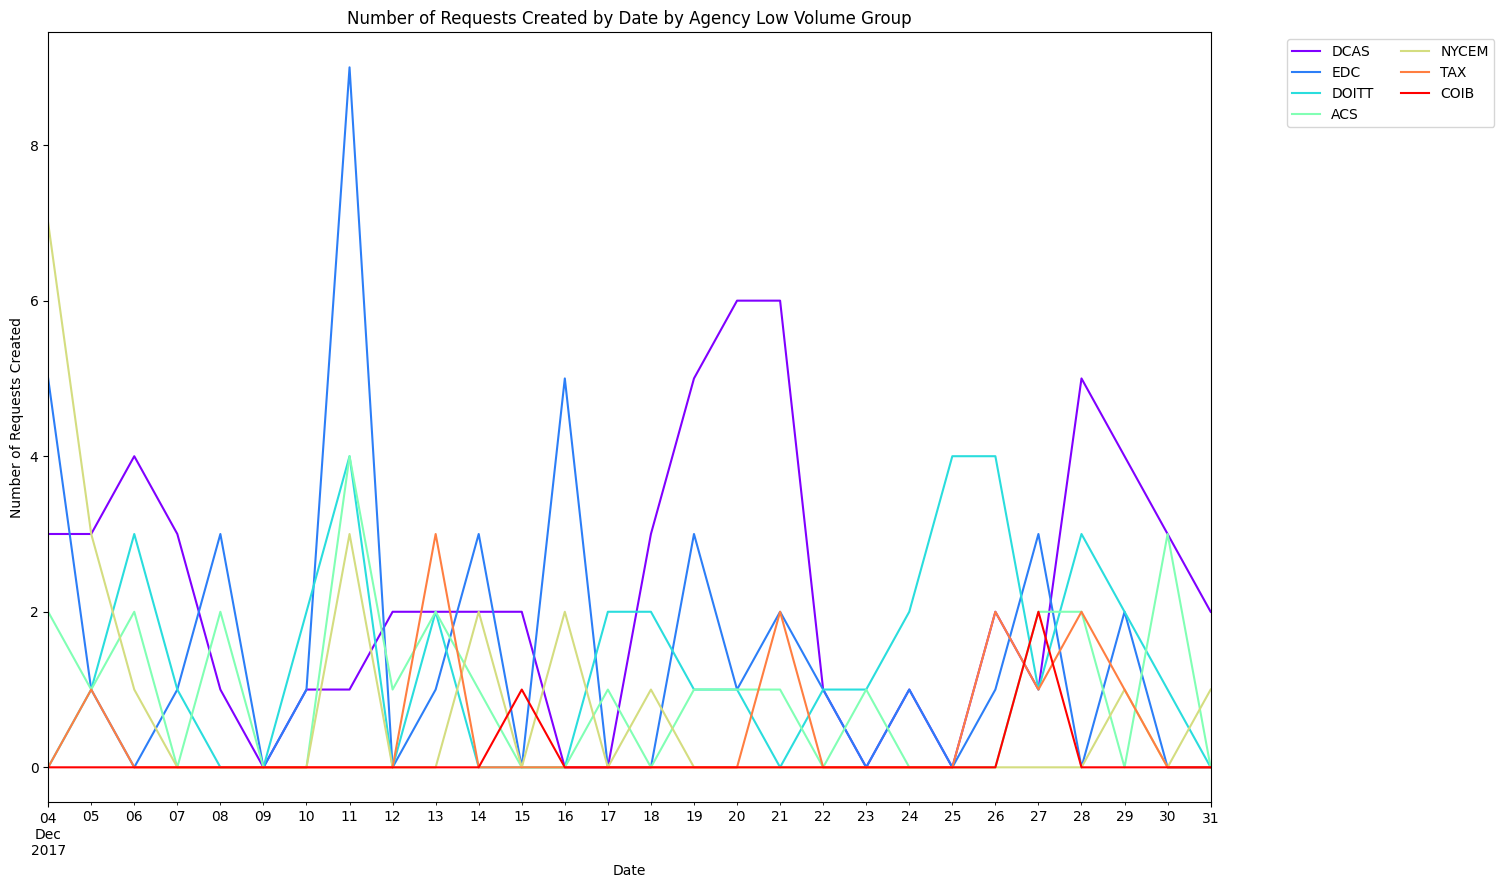

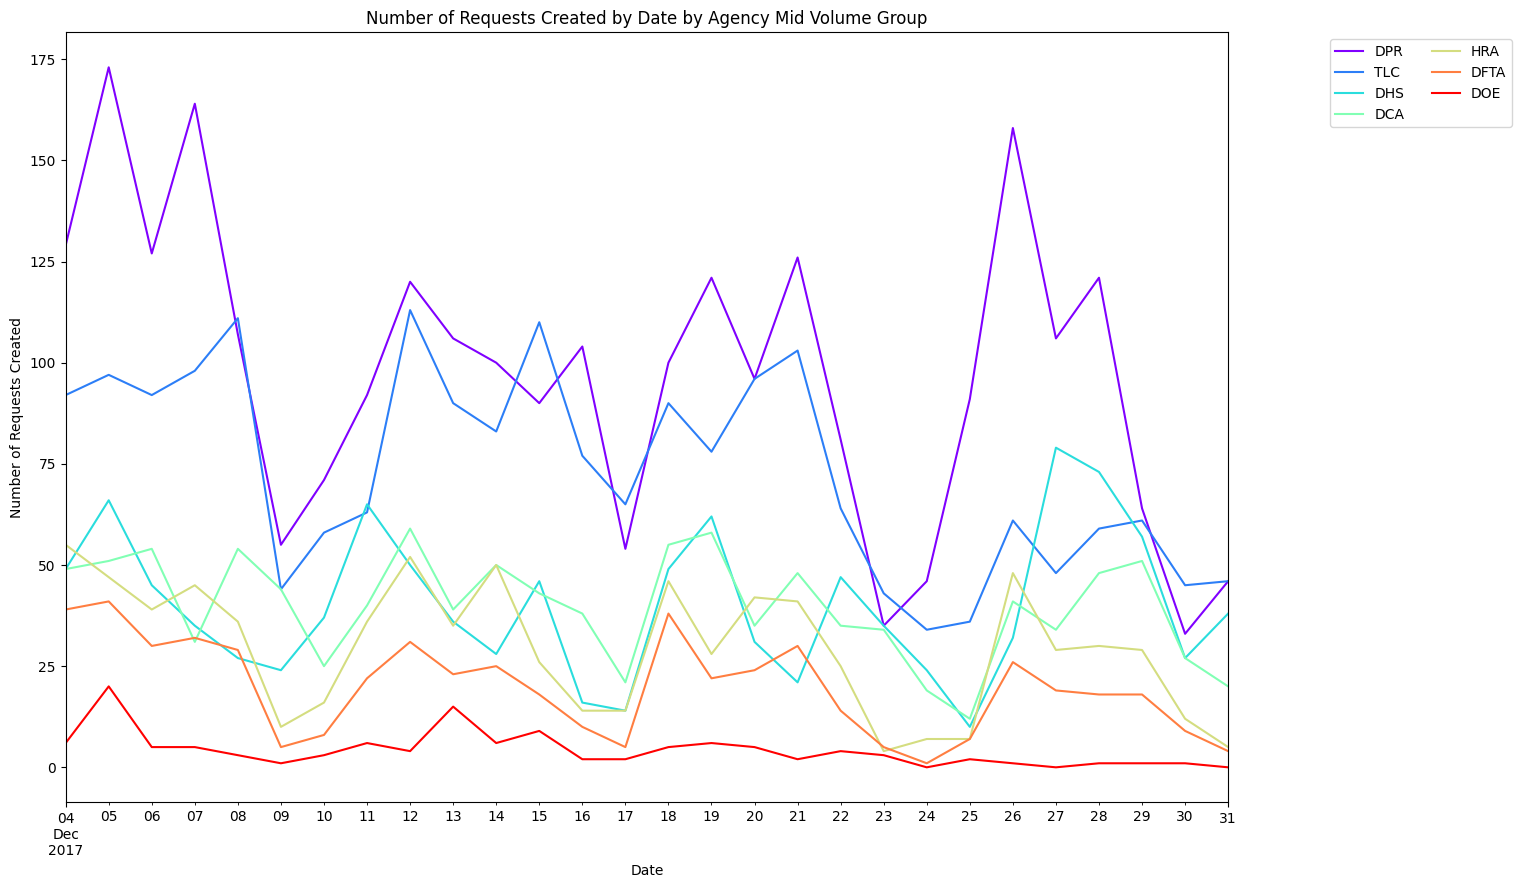

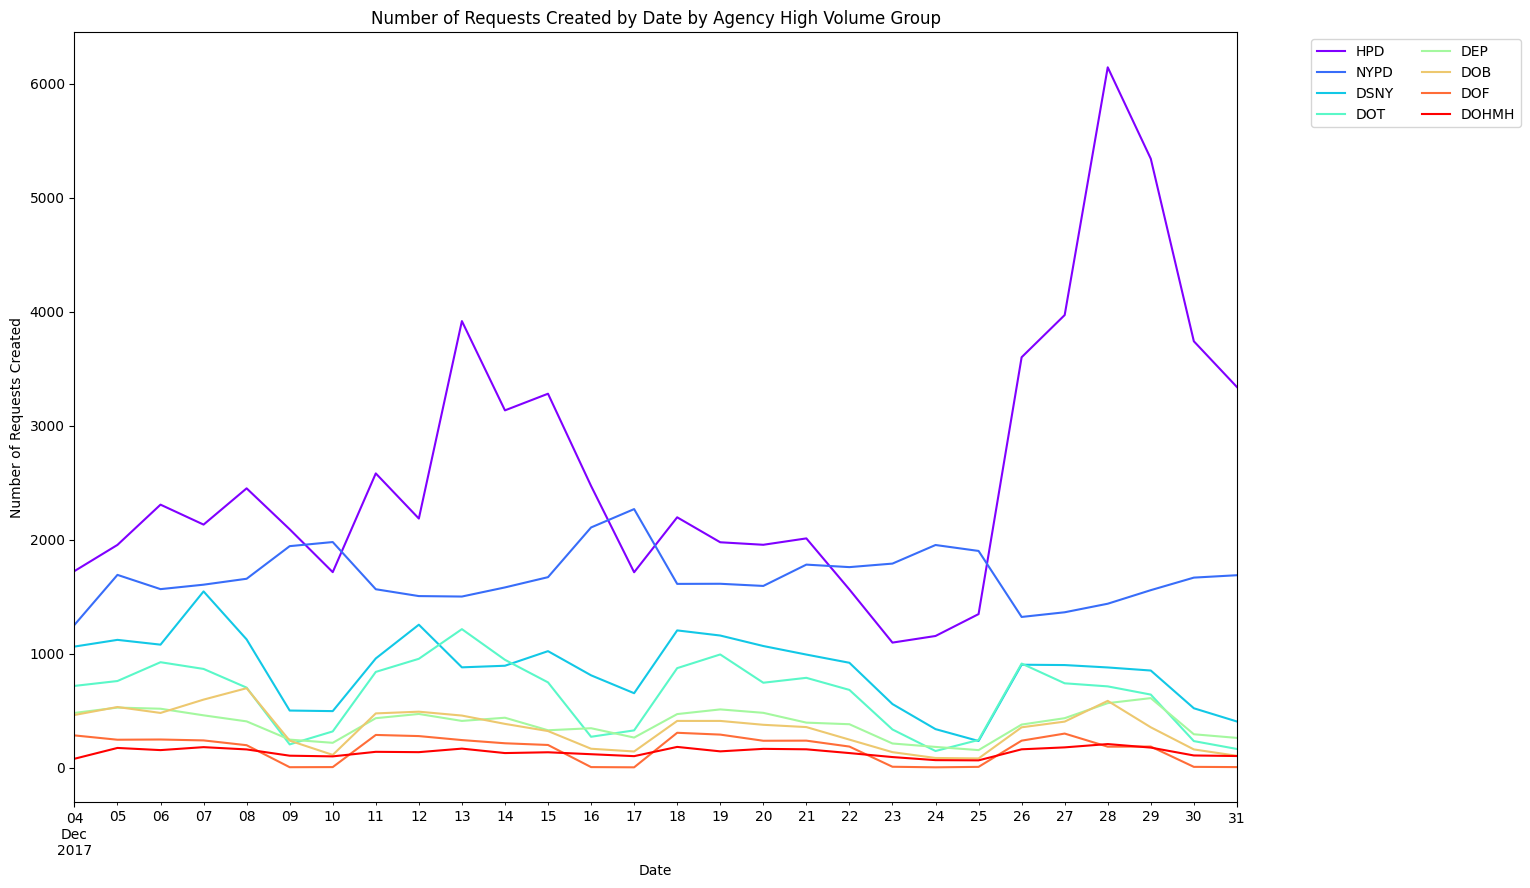

In [52]:
agency_created_date = cf.fillna(0)
agency_created_date = agency_created_date[agency_created_date.mean().sort_values(ascending=False).index]
bin_lbls = ["Low","Mid","High"]
q1, bins = pd.qcut(agency_created_date.mean(), 3, labels=bin_lbls, retbins=True,duplicates="raise")

for lbl in bin_lbls:
    l1 = agency_created_date[q1[q1==lbl].index]
    l1 = l1[l1.mean().sort_values(ascending=False).index]

    l1 = l1.set_index(pd.to_datetime(agency_created_date.index))
    ax = l1[:"2018-01-01"].plot(cmap=plt.cm.rainbow)
    # ax = agency_created[:"2018-01-01"].plot.area(stacked=True, cmap=plt.cm.RdGy)
    ax.legend(loc="upper right", ncol=2,bbox_to_anchor=[1.25,1])
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Requests Created")
    ax.set_title(f"Number of Requests Created by Date by Agency {lbl} Volume Group")
    fig = ax.get_figure()
    fig.set_size_inches(15,10)

-73.9232548285547 40.73390865622287


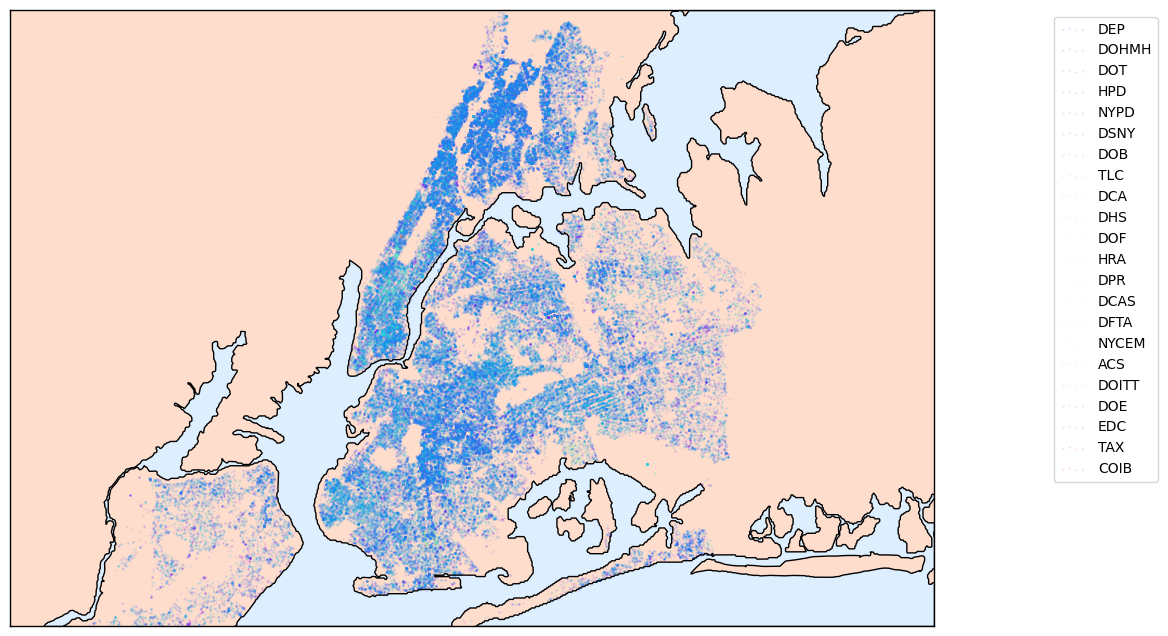

In [ ]:
agency = q2017_df["agency"].unique()
# Generate unique colors for each unique value
num_unique_values = len(agency)
colors = plt.cm.rainbow(np.linspace(0, 1, num_unique_values))

# Map unique values to unique colors
color_map = dict(zip(agency, colors))

avg_lat = q2017_df["latitude"].mean()
avg_lon = q2017_df["longitude"].mean()
print(avg_lon, avg_lat)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
m = Basemap(projection='gnom', lat_0=avg_lat, lon_0=avg_lon,
                width=60_000, height=40_000, resolution="f", ax=ax)
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

for group, color in color_map.items():
    group_data = q2017_df[q2017_df['agency'] == group]
    m.scatter(
        group_data["longitude"], group_data["latitude"],
        latlon=True, color=color, label=group, alpha = 0.1,
        s=0.5
        # c=q2017_df["agency"]
        )
ax.legend(loc="upper right", ncol=1,bbox_to_anchor=[1.25,1], scatterpoints=4)


In [ ]:
# Create Target Feature
q2017_df["time_to_complete"] = q2017_df["closed_date"] - q2017_df["created_date"]

In [ ]:
per_impossible = len(q2017_df[q2017_df["time_to_complete"]<pd.Timedelta(0)])/len(q2017_df) * 100
print(f"Percentage of negative completion times: {per_impossible:.3f}%")

Percentage of negative completion times: 0.646%


In [ ]:
time_to_complete = q2017_df["closed_date"] - q2017_df["created_date"]

q2017_df['hours_to_complete'] = time_to_complete.dt.total_seconds()//(3600)
per_impossible = len(q2017_df[q2017_df["time_to_complete"]<pd.Timedelta(0)])/len(q2017_df) * 100
print(f"Percentage of negative completion times: {per_impossible:.3f}%")

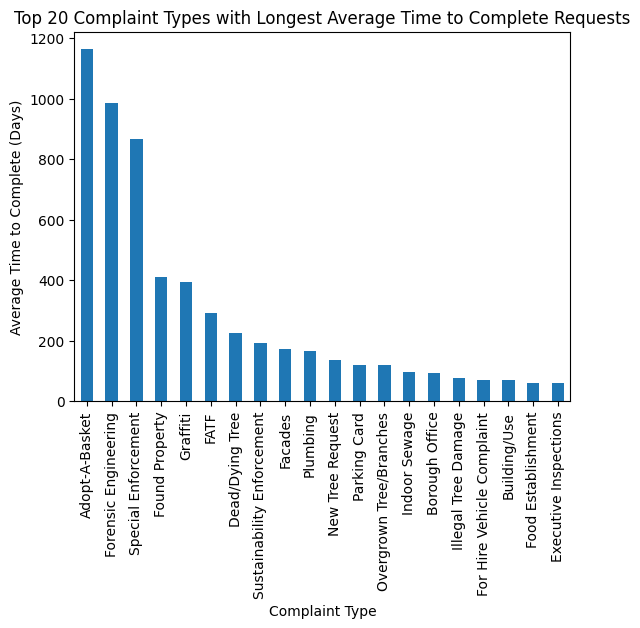

In [ ]:

# mean time to complete requests for each complaint type
mean_time_by_type = q2017_df.groupby("complaint_type")["days_to_complete"].mean()

# top 20 complaint types with the longest average time to complete requests
sorted_mean_time_by_type = mean_time_by_type.sort_values(ascending=False)
top_20_types = sorted_mean_time_by_type.head(20)

# plot them
top_20_types.plot.bar()

plt.title('Top 20 Complaint Types with Longest Average Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Average Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

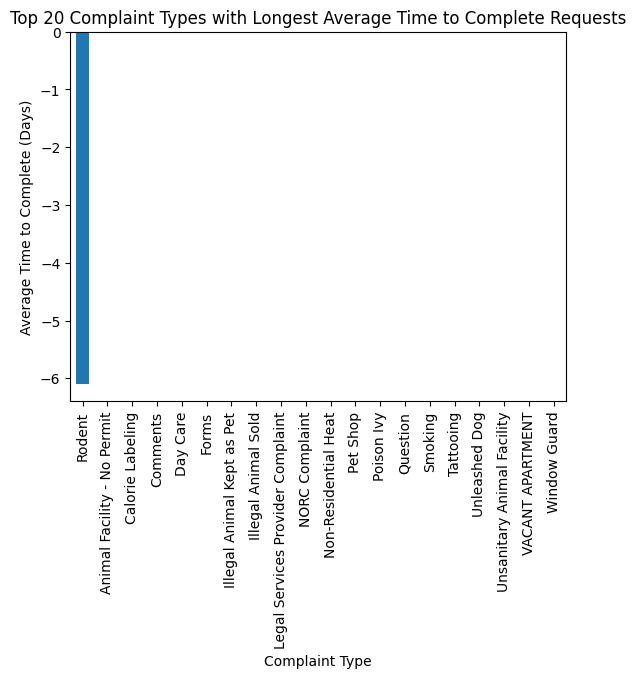

In [ ]:
bottom_20 = sorted_mean_time_by_type.tail(20)
# plot them
bottom_20.plot.bar()

plt.title('Top 20 Complaint Types with Longest Average Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Average Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

In [ ]:
# variance in time to complete requests for each complaint type
var_time_by_type = q2017_df.groupby("complaint_type")["days_to_complete"].var()

# top 20 complaint types with the longest variance in time to complete requests
sorted_var_time_by_type = var_time_by_type.sort_values(ascending=False)
top_20_var = sorted_var_time_by_type.head(20)

# plot them
top_20_var.plot.bar()

plt.title('Top 20 Complaint Types with Highest Variance in Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Variance in Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

In [ ]:
q2017_df["status"].unique()


array(['Pending', 'Closed', 'Open', 'Assigned', 'Email Sent', 'Started'],
      dtype=object)

In [ ]:
q2017_df["agency"].unique()

array(['DEP', 'DOHMH', 'DOT', 'HPD', 'NYPD', 'DSNY', 'DOB', 'TLC', 'DCA',
       'DHS', 'DOF', 'HRA', 'DPR', 'DCAS', 'DFTA', 'NYCEM', 'ACS',
       'DOITT', 'DOE', 'EDC', 'TAX', 'COIB'], dtype=object)

In [ ]:
q2017_df["complaint_type"].unique()


array(['FATF', 'Food Poisoning', 'Street Light Condition',
       'Traffic Signal Condition', 'HEAT/HOT WATER',
       'Noise - Residential', 'Illegal Parking',
       'Noise - Street/Sidewalk', 'WATER LEAK', 'Blocked Driveway',
       'DOOR/WINDOW', 'ELECTRIC', 'Noise - Commercial',
       'Request Large Bulky Item Collection', 'Water System', 'Plumbing',
       'PLUMBING', 'For Hire Vehicle Report', 'Noise - Vehicle', 'Noise',
       'Animal Abuse', 'Non-Residential Heat', 'Drug Activity',
       'PAINT/PLASTER', 'UNSANITARY CONDITION', 'GENERAL',
       'Consumer Complaint', 'For Hire Vehicle Complaint',
       'Taxi Complaint', 'Sewer', 'Smoking', 'Lead', 'Elevator', 'SAFETY',
       'Street Condition', 'General Construction/Plumbing',
       'Sanitation Condition', 'Missed Collection (All Materials)',
       'Homeless Encampment', 'FLOORING/STAIRS',
       'Homeless Person Assistance', 'Electronics Waste',
       'Noise - House of Worship', 'Snow', 'APPLIANCE',
       'Water Conse

In [ ]:
len(q2017_df["descriptor"].unique())


879

: 